# **SENTIMENT ANALYSIS - UNSUPERVISED**

# Initialization

In [2]:
import os
import json
import numpy as np
import spacy
import nltk
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer
from nltk.corpus import sentiwordnet as swn
from nltk.wsd import lesk
from sklearn.metrics import accuracy_score
from typing import Optional
import warnings
import re
from nltk.corpus import wordnet as wn

In [3]:
# Load datasets    
with open('./data/X_test.json', 'r') as file:
    X_test = json.load(file)
    
with open('./data/y_test.json', 'r') as file:
    y_test = json.load(file)

with open('./data/X_val.json', 'r') as file:
    X_val = json.load(file)

with open('./data/y_val.json', 'r') as file:
    y_val = json.load(file)

In [13]:
import nltk
from nltk.corpus import stopwords
 
nltk.download('stopwords')
stop_words = set(stopwords.words('english'))
nlp = spacy.load("en_core_web_sm")
lemmatizer = WordNetLemmatizer()
nltk.download('universal_tagset')

[nltk_data] Downloading package stopwords to C:\Users\Cai Selvas
[nltk_data]     Sala\AppData\Roaming\nltk_data...
[nltk_data]   Unzipping corpora\stopwords.zip.
[nltk_data] Downloading package universal_tagset to C:\Users\Cai
[nltk_data]     Selvas Sala\AppData\Roaming\nltk_data...
[nltk_data]   Unzipping taggers\universal_tagset.zip.


True

In [82]:
def fix_text(text:str) -> str:
    """
    Fix text by removing unwanted characters and adding spaces where needed.

    Parameters:
        text (str): Text to fix.

    Returns:
        str: Fixed text.
    """
    fixed_text = re.sub(r'[\\"\+\/]', '', text)
    fixed_text = re.sub(r'\s*([.,!\?;:])\s*', r'\1 ', fixed_text)
    fixed_text = re.sub(r'\s+\' s\s+', "'s ", fixed_text)
    fixed_text = re.sub(r'\s+\' t\s+', "'t ", fixed_text)
    fixed_text = re.sub(r'\s+\' re\s+', "'re ", fixed_text)
    fixed_text = re.sub(r'\s+\' ve\s+', "'ve ", fixed_text)
    fixed_text = re.sub(r'\s+\' ll\s+', "'ll ", fixed_text)
    fixed_text = re.sub(r'\s+', ' ', fixed_text)
    fixed_text = re.sub(r'\si\s', ' I ', fixed_text)
    fixed_text = re.sub(r'(?:^|(?<=[.!?]))\s*(\w)', lambda x: x.group(1).upper(), fixed_text)
    return fixed_text.strip()

def get_sentences(text:str, remove_stopwords:bool = False) -> list:
    """
    Get sentences from a text.

    Parameters:
        text (str): Text to analyze.
        remove_stopwords (bool): Whether to remove stopwords or not.
    
    Returns:
        list: List of sentences.
    """
    sent_list = nltk.sent_tokenize(text)
    if remove_stopwords:
        no_stopwords_sentences = []
        for sentence in sent_list:
            word_tokens = word_tokenize(sentence)
            filtered_sentence = [w for w in word_tokens if not w.lower() in stop_words]
            filtered_sentence = []
            for w in word_tokens:
                if w not in stop_words:
                    filtered_sentence.append(w)
            no_stopwords_sentences.append(filtered_sentence)
        return no_stopwords_sentences
    else:
        return sent_list
    

def get_sentiment(synset:'Synset') -> Optional[tuple]:
    """
    Get sentiment scores for a synset.

    Parameters:
        synset (Synset): Synset to analyze.

    Returns:
        tuple: Tuple with positive, negative and objective scores if synset is found. None otherwise.
    """
    sentiment = swn.senti_synset(synset)
    return (sentiment.pos_score(), sentiment.neg_score(), sentiment.obj_score()) if sentiment else None

def score_synsets(synsets:list, score:str = 'obj', threshold:float = 0.25, merge_scores:str = 'mean', default:float = 0, hide_warnings:bool = False) -> float:
    """
    Compute a score for each synset in a list of synsets and merge them into a single score.

    Parameters:
        synsets (list): List of synsets.
        score (str): Score to compute. One of 'pos', 'neg', 'obj', 'max_score', 'dif', 'dif2', 'dif_threshold', 'dif2_threshold'.
        threshold (float): Threshold for 'dif_threshold' and 'dif2_threshold' scores. Scores below this threshold are set to 0.
        merge_scores (str): Method for merging scores into a single score. One of 'sum', 'mean', 'max', 'min', 'scale_norm1_mean', 'scale_norm2_mean'.
        default (float): Default score to return if synsets is empty.
        hide_warnings (bool): Whether to hide warnings or not.
        
    Returns:
        float: Merged score.
    """
    if len(synsets) == 0:
        if not hide_warnings:
            warnings.warn(f"Empty synsets list. Returning default score ({default}).", SyntaxWarning)
        return default

    if score == 'max_score' and merge_scores not in ['sum', 'mean']:
        if not hide_warnings:
            warnings.warn(f"Score 'max_score' is not compatible with '{merge_scores}'. Using 'sum' instead.", SyntaxWarning)
        merge_scores = 'sum'

    dict_score = {
        'pos': lambda s: s[0],
        'neg': lambda s: s[1], 
        'obj': lambda s: s[2],
        'max_score': lambda s: (-1 if s[0] > s[1] else 1) if s[0] != s[1] else 0,
        'dif': lambda s: s[0] - s[1],
        'dif2': lambda s: s[0]**2 - s[1]**2,
        'dif_threshold': lambda s: (s[0] if abs(s[0]) >= threshold else 0) - (s[1] if abs(s[1]) >= threshold else 0),
        'dif2_threshold': lambda s: (s[0]**2 if abs(s[0]) >= threshold else 0) - (s[1]**2 if abs(s[1]) >= threshold else 0),
        }
    
    assert score in dict_score.keys(), f"Score '{score}' not valid. Choose one of {list(dict_score.keys())}"
    
    def min_max_scale(scores:list[float|int]) -> list[float]:
        """
        Compute min-max scaling of a list of scores.

        Parameters:
            scores (list): List of scores.

        Returns:
            list: Scaled scores.
        """
        min_score = min(scores)
        max_score = max(scores)
        return [(s - min_score) / (max_score - min_score) for s in scores]

    dict_merge = {
        'sum': lambda sc: sum(sc),
        'mean': lambda sc: np.mean(sc),
        'max': lambda sc: max(sc),
        'min': lambda sc: min(sc),
        'scale_norm1_mean': lambda sc: np.mean(np.abs(min_max_scale(sc))),
        'scale_norm2_mean': lambda sc: np.linalg.norm(min_max_scale(sc)) / len(sc),
    }
    
    assert merge_scores in dict_merge.keys(), f"Merge score '{merge_scores}' not valid. Choose one of {list(dict_merge.keys())}"

    score_func = dict_score[score]
    scores = [score_func(get_sentiment(synset=s)) for s in synsets if s is not None]

    if merge_scores in ['scale_norm1_mean', 'scale_norm2_mean'] and min(scores) == max(scores):
        if not hide_warnings:
            warnings.warn(f"Scores are all the same and cannot be scaled. Returning default score ({default}).", SyntaxWarning)
        return default


    merge_func = dict_merge[merge_scores]
    scores_merged = merge_func(scores)

    return scores_merged

def discretize_scores(scores:list, threshold:float, positive_value = 1, negative_value = 0) -> list:
    """
    Returns a list of binary values based on a threshold.

    Parameters:
        scores (list): List of scores.
        threshold (float): Minimum value to consider a score as positive.
        positive_value: Value to assign to positive scores.
        negative_value: Value to assign to negative scores.
    """
    return list(map(lambda x: positive_value if x >= threshold else negative_value, scores))


def negativize(sentence):
    """
    Based on https://gist.github.com/UtkarshRedd/3fbfd354ea7a6f83bd8f9419a27b0543
    """
    for i in range(2, len(sentence)):
        for distance in [1,2]:
            if sentence[i-distance] in ['not', "n't", "t", "DELETED"]:
                antonyms = []
                for syn in wn.synsets(sentence[i]):
                    for l in syn.lemmas():
                        if l.antonyms():
                            antonyms.append(l.antonyms()[0].name())
                max_dissimilarity = 0
                antonym_max = None
                for ant in antonyms:
                    for syn in wn.synsets(ant):
                        w1 = wn.synsets(sentence[i])[0].name()
                        w2 = syn.name()
                        word1 = wn.synset(w1)
                        word2 = wn.synset(w2)
                        if isinstance(word1.path_similarity(word2), (float, int)):
                            temp = 1 - word1.path_similarity(word2)
                            if temp > max_dissimilarity:
                                max_dissimilarity = temp
                                antonym_max = ant
                if antonym_max:
                    sentence[i] = antonym_max
                    sentence[i-distance] = 'DELETED'
    sentence = [word for word in sentence if word != 'DELETED']
    return sentence

# LESK

In [62]:
def get_lesk_synsets(text:str, lemmatize:bool = False, remove_stopwords:bool = False, negatives:bool = False):
    tokens = word_tokenize(text)
    tagged_tokens = []
    if lemmatize:
        tokens = [lemmatizer.lemmatize(token) for token in tokens]
    if remove_stopwords:
        tokens = [w for w in tokens if not w.lower() in stop_words]
    if negatives:
        tokens = negativize(tokens)
    if lemmatize or remove_stopwords or negatives:
        tagged_tokens = [a for a in nltk.pos_tag(tokens, tagset="universal")]
    else:
        tagged_tokens = [(a.text, a.pos_) for a in nlp(text)]
    words = []
    for token, pos in tagged_tokens:
        if pos == "NOUN":
            syn = lesk(tokens, token, pos="n")
        elif pos == "ADJ":
            syn = lesk(tokens, token)
        elif pos == "ADV":
            syn = lesk(tokens, token, pos="r")
        elif pos == "VERB":
            syn = lesk(tokens, token, pos="v")
        else:
            syn = None
        if syn is not None:
            words.append(syn)
    return words

def get_lesk_all_synsets(sentences:list, lemmatizer:bool = True) -> list:
    all = []
    for sentence in sentences:
        all.append(get_lesk_synsets(sentence, lemmatizer))
    return all

In [63]:
test_synsets = []
i = 0
for opinion in X_test:
    s = get_sentences(opinion)
    #s = [fix_text(t) for t in s]
    syns = get_lesk_all_synsets(s, lemmatizer=False)
    names = [[syn.name() for syn in ll] for ll in syns]
    test_synsets.append(names)

In [ ]:
with open('./data/lesk_test_s_synsets.json', 'w') as file:
    json.dump(test_synsets, file)

In [8]:
val_synsets = []
for opinion in X_val:
    s = get_sentences(opinion)
    #s = [fix_text(t) for t in s]
    syns = get_lesk_all_synsets(s)
    names = [[syn.name() for syn in ll] for ll in syns]
    val_synsets.append(names)

In [9]:
with open('./data/lesk_val_s_synsets.json', 'w') as file:
	json.dump(val_synsets, file)

# UKB

Own implementation of UKB since TextServer didn't allow us.

In [10]:
from ukb import *
nlp = spacy.load("en_core_web_sm")
try:
    ukb_graph = load_ukb_graph("ukb_graph.gexf")
except:
    print("Creating graph...")
    ukb_graph = build_ukb_graph()
    nx.write_gexf(ukb_graph, "ukb_graph.gexf")

ukb = UKB(ukb_graph)
def get_ukb_synsets(text:str):
    context_words = extract_context_words(text)
    disambiguated_senses = ukb.disambiguate_context(context_words, method=1)
    return list(disambiguated_senses.values())

def get_ukb_all_synsets(sentences:list) -> list:
    all = []
    for sentence in sentences:
        all.append([a for a in get_ukb_synsets(sentence) if a != None])
    return all

In [9]:
context_words = extract_context_words("find the solution to this problem electro latino house rock music what hell sky")
disambiguated_senses = ukb.disambiguate_context(context_words, method=1)
print(disambiguated_senses)

{'find': 'find.v.01', 'solution': 'solution.n.01', 'problem': 'problem.n.01', 'electro': None, 'latino': 'latin_american.n.01', 'house': 'house.n.06', 'rock': 'rock.n.02', 'music': 'music.n.01', 'hell': 'hell.n.03', 'sky': 'sky.n.01'}


In [7]:
test_synsets = []
for i, opinion in enumerate(X_test):
    s = get_sentences(opinion)
    #s = [fix_text(t) for t in s]
    syns = get_ukb_all_synsets(s)
    test_synsets.append(syns)
    print(i, end="\r")

In [8]:
with open('./data/ukb2_test_synsets2.json', 'w') as file:
    json.dump(test_synsets, file)

In [11]:
val_synsets = []
for i, opinion in enumerate(X_val):
    s = get_sentences(opinion)
    #s = [fix_text(t) for t in s]
    syns = get_ukb_all_synsets(s)
    val_synsets.append(syns)
    print(i, end="\r")

{'bone': 10.0, 'punch': 10.0, 'drunk': 10.0, 'mess': 10.0, 'movie': 10.0}
play.v.01 1.4148416219326865e-05
play.v.02 1.2618192684017028e-06
play.v.03 4.49286384795937e-06
act.v.03 4.225458786693964e-06
play.v.05 3.3042400764016784e-06
play.v.06 5.569272135755149e-06
play.v.07 6.221148766560443e-06
act.v.05 1.5173082997579784e-06
play.v.09 1.236635541270308e-06
play.v.10 1.5538398458485077e-06
play.v.11 5.900878068779482e-07
play.v.12 1.333637400357774e-06
play.v.13 1.4634277403837257e-06
play.v.14 1.2643134902244133e-06
play.v.15 2.8640701028564994e-06
play.v.16 1.5173082997579784e-06
play.v.17 1.2618192684017028e-06
play.v.18 5.900878068779482e-07
toy.v.02 1.6830260563856658e-06
play.v.20 1.2245979009496693e-06
dally.v.04 1.2310401306906855e-06
play.v.22 5.900878068779482e-07
dally.v.01 1.2618192684017028e-06
play.v.24 1.133446407876827e-06
act.v.10 3.6448759355021432e-06
play.v.26 1.1685811806874933e-06
bring.v.03 1.1814690220650054e-06
play.v.28 1.164459156183756e-06
play.v.29 1.151

KeyboardInterrupt: 

In [ ]:
with open('./data/ukb2_val_synsets.json', 'w') as file:
	json.dump(val_synsets, file)

# Frequencies

Using just the most freqüent synset

In [524]:
frequencies = json.load(open("./data/word_sense_frequencies_semcor.json"))

def get_freq_synsets(text:str):
    tokens = word_tokenize(text)
    tagged_tokens = [(a.text, a.pos_) for a in nlp(text)]
    words = []
    for token, pos in tagged_tokens:
        if token not in frequencies.keys():
            syn = None
        else:
            if pos == "NOUN":
                syn = max(frequencies[token], key=lambda key: frequencies[token][key])
            elif pos == "ADJ":
                syn = max(frequencies[token], key=lambda key: frequencies[token][key])
            elif pos == "ADV":
                syn = max(frequencies[token], key=lambda key: frequencies[token][key])
            elif pos == "VERB":
                syn = max(frequencies[token], key=lambda key: frequencies[token][key])
            else:
                syn = None
        if syn is not None:
            words.append(syn.name() if syn.__class__.__name__ == "Lemma" else syn)
    return words

def get_freq_all_synsets(sentences:list) -> list:
    all = []
    for sentence in sentences:
        all.append([a for a in get_freq_synsets(sentence) if a != None])
    return all



In [525]:
test_synsets = []
for i, opinion in enumerate(X_test):
    s = get_sentences(opinion)
    #s = [fix_text(t) for t in s]
    syns = get_freq_all_synsets(s)
    test_synsets.append(syns)
    print(i, end="\r")

In [526]:
with open('./data/freq_test_synsets.json', 'w') as file:
    json.dump(test_synsets, file)

In [5]:
with open('./data/ukb1_test_synsets.json', 'r') as file:
	test_synsets = json.load(file)

In [6]:
allowed = [  "v", "a", "s", "n"]

In [11]:
new_test_synsets = []

for opinion in test_synsets:
    new_opinion = []
    for sentence in opinion:
        filter_sentence = [name for name in sentence if name != "NE" and name.split('.')[1] in allowed]
        new_filter_sentence = []
        for a in filter_sentence:
            if "Lemma('" in a :
                n = a.replace("Lemma('", "").replace("')", "")
                n = n.split(".")
                n.pop(-1)
                n = ".".join(n)
            else:
                n = a
            try:
                get_sentiment(n)
                new_filter_sentence.append(n)
            except:
                print(n)
                pass
            
        filter_sentence = new_filter_sentence
        new_opinion.append(filter_sentence)
    new_test_synsets.append(new_opinion)

gifted.s.00
non.s.00
condensed.s.00
railway.n.1;2
anti.s.00
post.s.00
anti.s.00
growing.s.00
talented.s.00
ish.s.00
lingering.s.00
hearted.a.00
semi.s.00
post.s.00
post.s.00
gifted.s.00
post.s.00
bloated.s.00
touring.s.00
growing.s.00
anti.s.00
anti.s.00
spark.n.2;1
growing.s.00
talented.s.00
finest.s.00
biggest.s.00
talented.s.00
bloated.s.00


wares.n.00
growing.s.00
non.s.00
talented.s.00
guerrilla.s.00
depressing.s.00
post.s.00
anti.s.00
tuned.s.00
hearted.a.00
slightest.s.00
spark.n.2;1
multi.s.00
growing.s.00
furnishings.n.00
growing.s.00
anti.s.00
growing.s.00
tuned.s.00
growing.s.00
growing.s.00
depressing.s.00
sweaty.s.00
anti.s.00
growing.s.00
pre.s.00
spark.n.2;1
infested.s.00
semi.s.00
talented.s.00
talented.s.00
talented.s.00
biggest.s.00
haired.s.00
compassionate.s.00
sway.v.0;1
unbearable.s.00
non.s.00
depressing.s.00
goods.n.00
non.s.00
anti.s.00
scrap.s.00
rotting.s.00
smart.s.0;2
consist_of.v.00
talented.s.00
whining.s.00
rival.s.00
millions.n.00
post.s.00
semi.s.00
calming.s.00
growing.s.00
sandy.s.00
depressing.s.00
lingering.s.00
lower.s.00
post.s.00
birthe.v.00
lower.s.00
rival.s.00
spark.n.2;1
pre.s.00
spark.n.2;1
depressing.s.00
biggest.s.00
multi.s.00
semi.s.00
non.s.00
slightest.s.00
growing.s.00
consist_of.v.00
anti.s.00
consist_of.v.00
spoil.v.3;1
pilot.s.00
carping.s.00
sunshiny.s.00
reserve.s.00
p

In [12]:
with open('./data/freq_test_synsets.json', 'w') as file:
    json.dump(new_test_synsets, file)

# Testing

In [35]:
with open('./data/lesk_test_negative_synsets.json', 'r') as file:
    test_synsets = json.load(file)

with open('./data/lesk_val_synsets.json', 'r') as file:
    val_synsets = json.load(file)

In [86]:
def validation(val_synsets:list, 
                          y_val:list, 
                          allowed:list = ["n", "a","s", "v"],
                          scores:list = ['pos', 'neg', 'obj', 'max_score', 'dif', 'dif2', 'dif_threshold', 'dif2_threshold'],
                          scores_thresholds:list = [0.1, 0.25, 0.4, 0.5, 0.6, 0.75],
                          merges:list = ['sum', 'mean', 'max', 'min', 'scale_norm1_mean', 'scale_norm2_mean'],
                          thresholds = [-0.4, -0.25, -0.1, 0, 0.1, 0.25, 0.4, 0.5, 0.6, 0.75, 1]
                          ) -> tuple[tuple, dict]:
    """
    Run a validation experiment with different parameters to find the best combination.

    Parameters:
        val_synsets (list): List of validation synsets.
        y_val (list): List of validation labels.
        allowed (list): Allowed POS tags.
        scores (list): List of scores to compute.
        scores_thresholds (list): List of thresholds for 'dif_threshold' and 'dif2_threshold' scores.
        merges (list): List of methods to merge scores.
        thresholds (list): List of thresholds for discretization.
    
    Returns:
        tuple: Best parameters (tuple) and all results (dict).
    """
    import itertools
    results = []
    allow_combinations = list(itertools.chain.from_iterable(itertools.combinations(allowed, r) for r in range(1, len(allowed)+1)))
    iter = 1
    total_iters = len(scores) * len(merges) * len(thresholds) * len(allow_combinations)
    for score in scores:
        for merge in merges:
            for thresh in thresholds:
                for allow in allow_combinations:
                    print(f"Running validation: {(iter/total_iters)*100:.2f}%", end="\r")
                    iter += 1

                    if score == 'max_score' and merge not in ['sum', 'mean']:
                        results[(score, None, merge, thresh)] = float('nan')
                        continue

                    elif score in ['dif_threshold', 'dif2_threshold']:
                        for score_thresh in scores_thresholds:
                            acc = run_experiment(synsets=val_synsets, y=y_val, allowed=list(allow), score=score, score_thresh=score_thresh, merge=merge, thresh=thresh, hide_warnings=True)
                            results[(score, score_thresh, merge, thresh)] = acc
                    else:
                        acc = run_experiment(synsets=val_synsets, y=y_val, allowed=list(allow), score=score, merge=merge, thresh=thresh, hide_warnings=True)
                        results[(score, None, merge, thresh)] = acc

    best_params = max(results, key=lambda k: results[k])

    return best_params, results

def run_experiment(synsets:list, y:list, allowed:list, score:str, merge:str, thresh:float, score_thresh:float = 0, hide_warnings:bool = False) -> float:
    """
    Run an experiment with a set of parameters.

    Parameters:
        synsets (list): List of synsets.
        y (list): List of labels.
        allowed (list): Allowed POS tags.
        score (str): Score to compute.
        merge (str): Method to merge scores.
        thresh (float): Threshold for discretization.
        score_thresh (float): Threshold for 'dif_threshold' and 'dif2_threshold' scores.
        hide_warnings (bool): Whether to hide warnings or not.

    Returns:
        float: Accuracy obtained with the given parameters.
    """
    scores_opinions = []
    for opinion in synsets:
        scores_sentences = []
        for sentence in opinion:
            filter_sentence = [name for name in sentence if name.split('.')[1] in allowed]
            scores_sentences.append(score_synsets(synsets=filter_sentence, score=score, merge_scores=merge, threshold=score_thresh, hide_warnings=hide_warnings))

        scores_opinions.append(np.mean(scores_sentences))

    results_opinions = discretize_scores(scores=scores_opinions, threshold=thresh)

    accuracy = accuracy_score(y, results_opinions)

    return accuracy

In [87]:
best_params, results = validation(val_synsets=val_synsets, y_val=y_val)

In [88]:
print(f"Best parameters: Score: {best_params[0]}, Score threshold: {best_params[1]}, Merge: {best_params[2]}, Threshold: {best_params[3]}")
print(f"Accuracy: {results[best_params]:.4f}")

Best parameters: Score: dif, Score threshold: None, Merge: sum, Threshold: 0.1
Accuracy: 0.6507


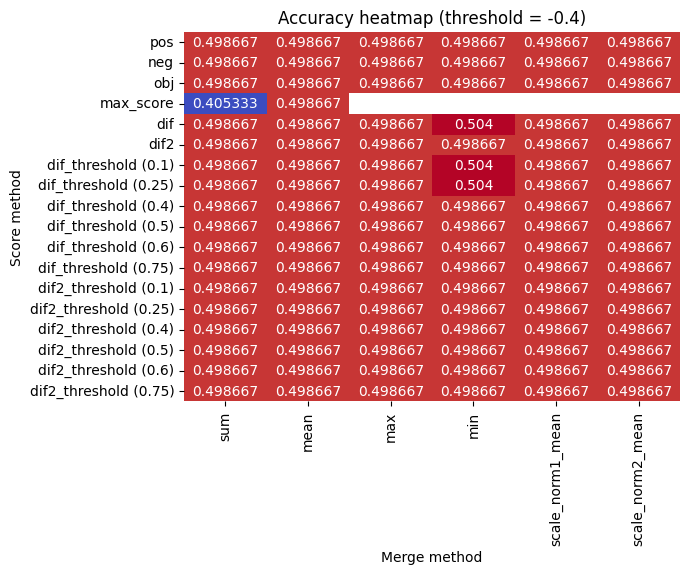

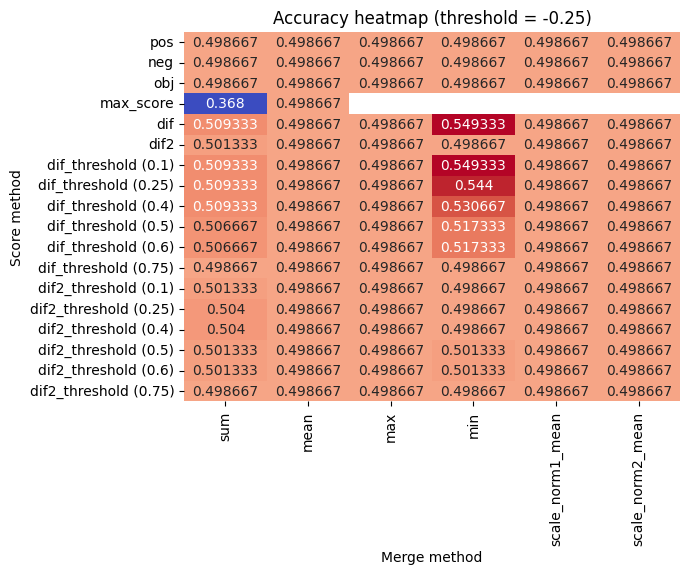

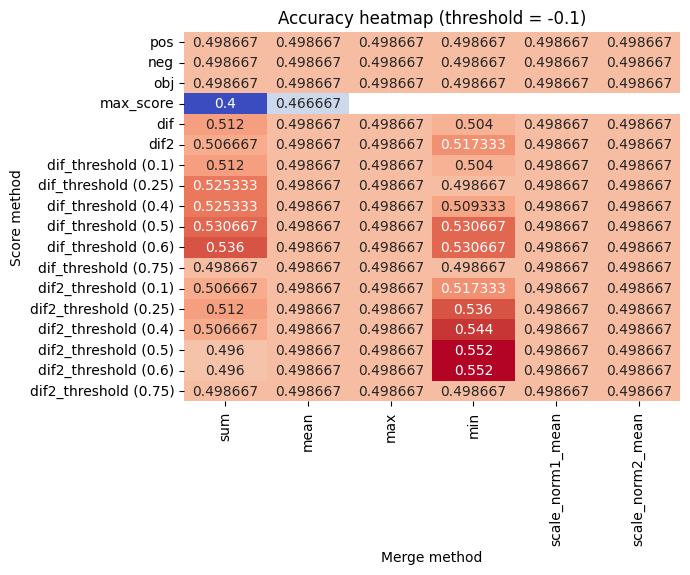

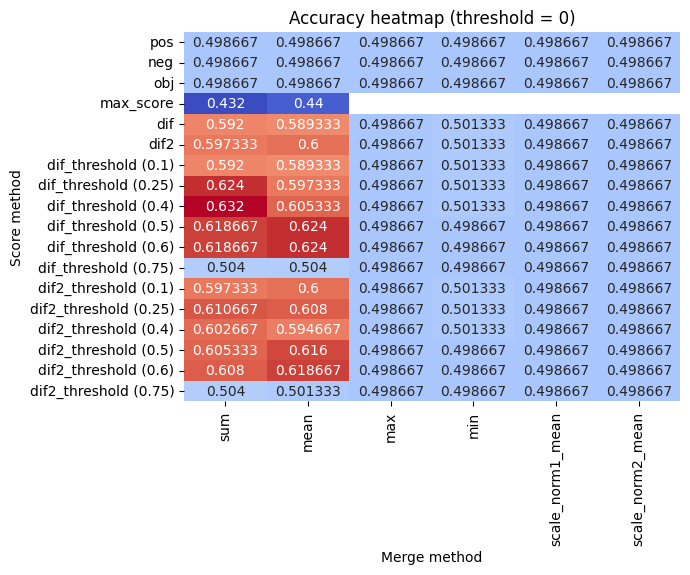

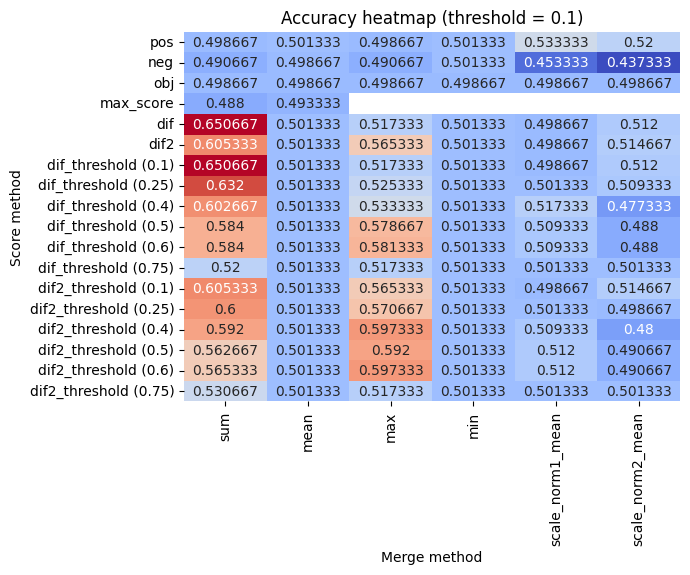

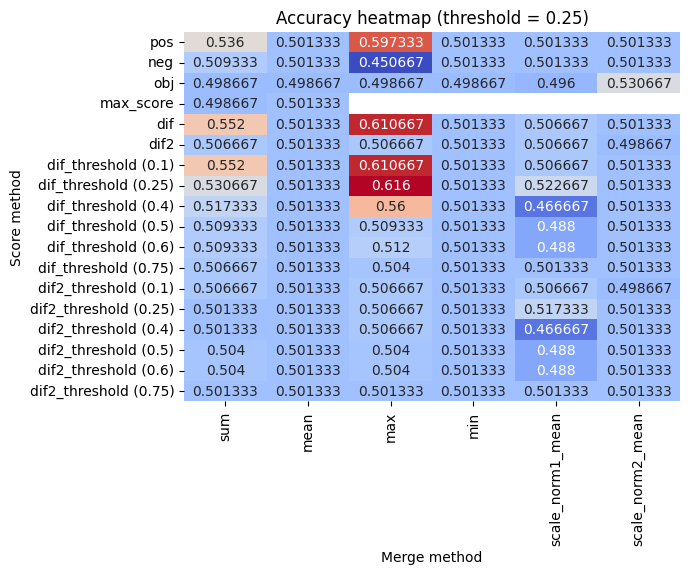

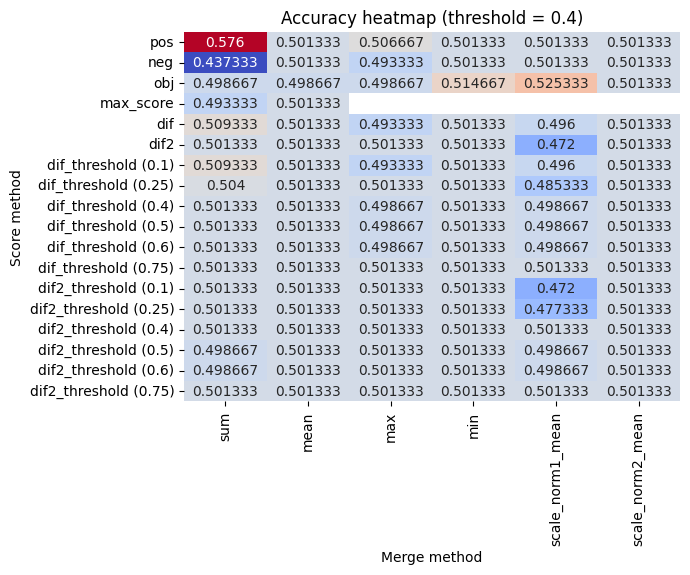

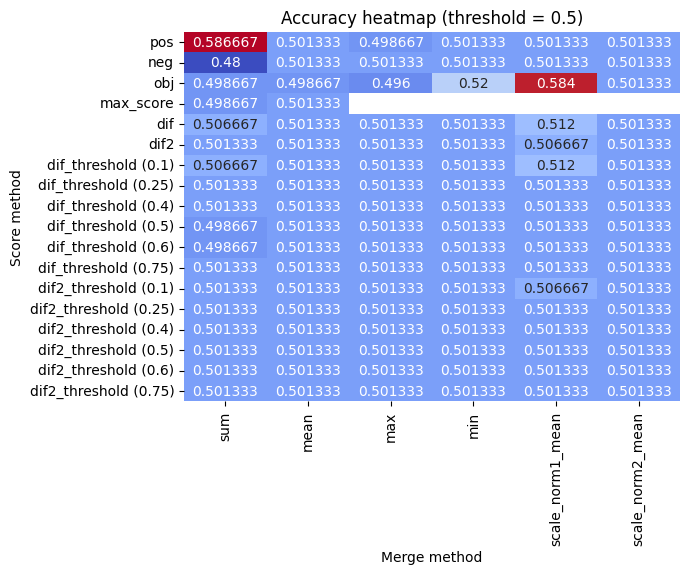

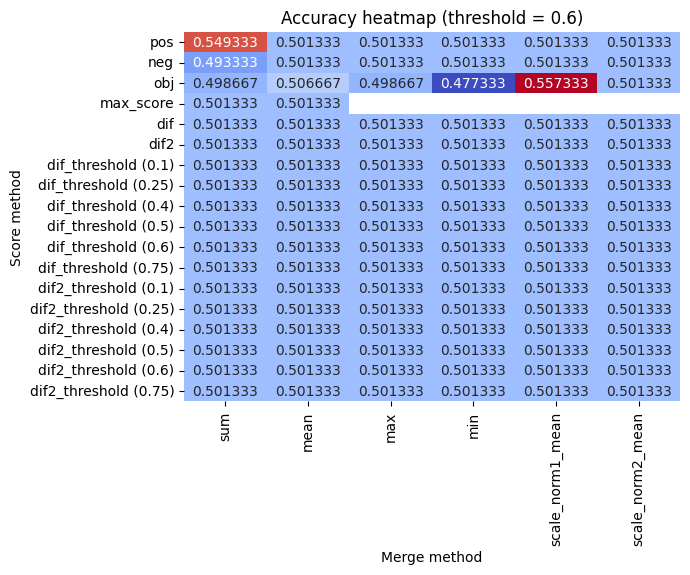

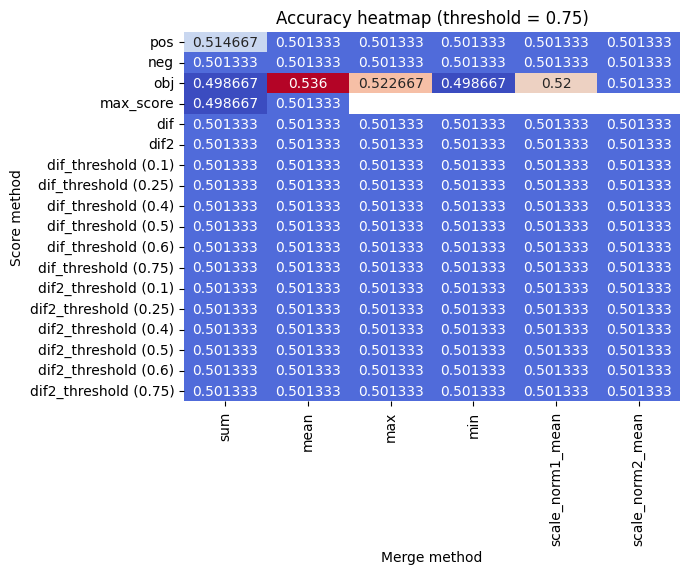

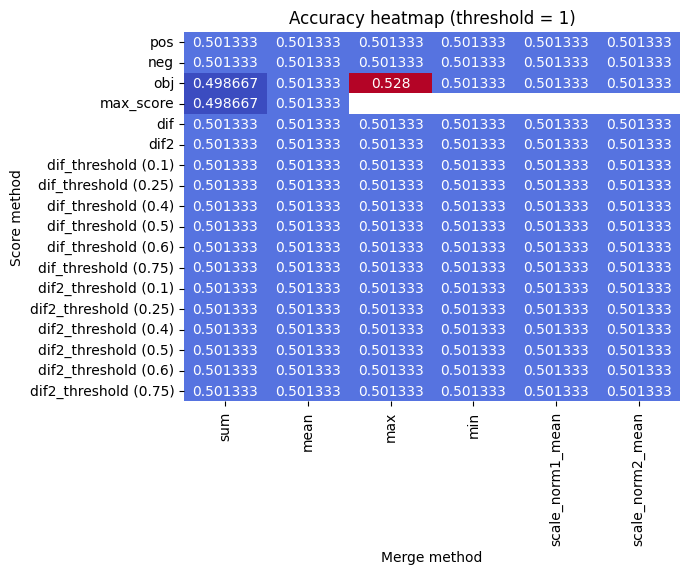

In [91]:
import seaborn as sns
import matplotlib.pyplot as plt

scores = [('pos', None), ('neg', None), ('obj', None), ('max_score', None), ('dif', None), ('dif2', None)]
scores_thresholds = [0.1, 0.25, 0.4, 0.5, 0.6, 0.75]
scores = scores + [('dif_threshold', score_thresh) for score_thresh in scores_thresholds] + [('dif2_threshold', score_thresh) for score_thresh in scores_thresholds]
merges = ['sum', 'mean', 'max', 'min', 'scale_norm1_mean', 'scale_norm2_mean']
thresholds = [-0.4, -0.25, -0.1, 0, 0.1, 0.25, 0.4, 0.5, 0.6, 0.75, 1]

scores_ticks = [f"{score[0]} ({score[1]})" if score[1] is not None else score[0] for score in scores]

results_matrix = np.zeros((len(scores), len(merges)))

for thresh in thresholds:
	for i, score in enumerate(scores):
		for j, merge in enumerate(merges):
			results_matrix[i, j] = results[(score[0], score[1], merge, thresh)]

	sns.heatmap(results_matrix, annot=True, xticklabels=merges, yticklabels=scores_ticks, fmt='g', cmap='coolwarm', cbar=False)
	plt.xlabel('Merge method')
	plt.ylabel('Score method')
	plt.title(f'Accuracy heatmap (threshold = {thresh})')
	plt.show()

In [ ]:
# Single execution with test set
run_experiment(synsets=test_synsets, y=y_test, allowed=['n', 'a', 's', 'v'], score='dif', merge='sum', thresh=0.1)

In [60]:
with open('./data/lesk_test_synsets.json', 'r') as file:
    test_synsets = json.load(file)

allowed=['n', 'a', 's' 'v']
results = []
scores_obj = []
scores_res = []
for opinion in test_synsets:
    total_pos = 0
    total_neg = 0
    total_obj = 0
    for sentence in opinion:
        filter_sentence = [name for name in sentence if name.split('.')[1] in allowed]
        scores = [get_sentiment(syn) for syn in filter_sentence if get_sentiment(syn) != None]
        if len(scores) > 0:
            total_pos += sum(s[0] for s in scores if s[0] > 0.5) / len(scores)
            total_neg += sum(s[1] for s in scores if s[1] > 0.5) /len(scores)
            total_obj += sum(s[2] for s in scores) /len(scores)
    score = total_obj
    scores_obj.append(total_obj)
    scores_res.append(total_pos - total_neg)
    if score > 0.15:
        # print("Positive")
        results.append(1)
    elif score < 0.15:
        # print("Negative")
        results.append(0)
    else:
        # print("Neutral")
        results.append(0)
results = [0 if a < 0.00 else 1 for a in scores_res]
print(accuracy_score(y_test, results))


0.616


# Alternatives

There are other approaches that can be also useful.

In [16]:
import nltk
from nltk.tokenize import sent_tokenize
from nltk.sentiment.vader import SentimentIntensityAnalyzer
nltk.download('vader_lexicon')
analyzer = SentimentIntensityAnalyzer()

scores_opinions = []
for opinion in X_test:
    scores_sentences = []
    for sentence in sent_tokenize(opinion):
        scores = analyzer.polarity_scores(sentence)
        resta = scores["pos"] - scores["neg"]
        scores_sentences.append(resta)
    scores_opinions.append(np.mean(scores_sentences))

results_opinions = discretize_scores(scores=scores_opinions, threshold=0.06)

accuracy_score(y_test, results_opinions)


[nltk_data] Downloading package vader_lexicon to
[nltk_data]     C:\Users\Usuario\AppData\Roaming\nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!


0.64

In [25]:
results_opinions = discretize_scores(scores=scores_opinions, threshold=0.015)
accuracy_score(y_test, results_opinions)

0.668